In [13]:
%matplotlib inline

# Version 2 du modèle prédictif

Dans ce notebook, nous allons améliorer le modèle V1 en prenant en compte d'autres prédicteurs dans le modèle linéaire. 

On commence par importer les données dont on aura besoin (le tout est rassemblé en une seule cellule cette fois-ci) :

In [32]:
import pandas as pd
import numpy as np

league = pd.read_csv('data\\league.csv', index_col=0)
team = pd.read_csv('data\\team.csv', index_col=0)
match = pd.read_csv('data\\match.csv', index_col=0, parse_dates=[6], infer_datetime_format=True)

match.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 
            'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], 
           axis=1, inplace=True)

match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
            'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
            'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
            'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
            'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
            'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
            'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
            'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
            'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
            'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
            'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
            'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 
            'away_player_9', 'away_player_10', 'away_player_11'],
          axis=1, inplace=True)

# On ajoute le nom complet des équipes
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='home_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'home_team_long_name'}, inplace=True)
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='away_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'away_team_long_name'}, inplace=True)

match.drop(['team_api_id_y', 'team_api_id_x'], axis=1, inplace=True)

match.drop(['country_id', 'season', 'stage', 'match_api_id'],
           axis=1, inplace=True)

# On trie par date et on reindex
match.sort_values(by='date', inplace=True)
match.index = range(0,len(match))

match.head()

,id,league_id,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,home_team_long_name,away_team_long_name
0,24559,24558,2008-07-18,10192,9931,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BSC Young Boys,FC Basel
1,24560,24558,2008-07-19,9930,10179,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC Aarau,FC Sion
2,24561,24558,2008-07-20,10199,9824,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC Luzern,FC Vaduz
3,24562,24558,2008-07-20,7955,10243,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Neuchâtel Xamax,FC Zürich
4,24615,24558,2008-07-23,10243,10199,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC Zürich,FC Luzern


On va maintenant construire les nouvelles variables à partir des informations à disposition, à savoir :
- le temps de récupération (ie. le nombre de jours entre le dernier match et le jour j)
- le nombre de matchs dans le mois
- la dynamique : c'est l'historique des 5 derniers matchs (ex: GGPPN)
- le nombre de buts ajustés : on va pour cela considérer
    - les buts qui permettent à une équipe de mener compte 1.2
    - les tirs cadrés par rapport à la position (distance + angle) (pondération à définir)
    - somme tirs cadrés + tirs non cadrés
    - ratio tirs cadrés / tirs non cadrés
    - compter 0.8 un but quand l'équipe adverse s'est prise en carton rouge
    - corner, coup franc indirect comptent pour 0.1 ?
    

## Conditions du match

Commençons par le temps de récupération :

In [33]:
def calcul_recup(row, home=True):    
    # on récupère l'équipe et la date du match
    if home:
        equipe, jourJ = (row.home_team_api_id, row.date)
    else:
        equipe, jourJ = (row.away_team_api_id, row.date)
      
    # on récupère tous les matchs précédents de l'équipe
    match_precedents = match[:row.name][(match.home_team_api_id == equipe) | (match.away_team_api_id == equipe)]
    
    # Si il n'y en a aucun, on compte le maximum de récupération, sinon on retourne le nombre de jours
    if match_precedents.id.count() == 0:
        return 15
    else:
        deltaT = np.min(jourJ - match_precedents.date)
        return min(deltaT.days, 15)
    
match['recuperation_home'] = match.apply(lambda row: calcul_recup(row), axis=1)
match['recuperation_away'] = match.apply(lambda row: calcul_recup(row, home=False), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


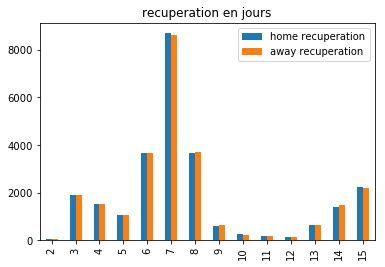

In [34]:
df_home = pd.DataFrame(match['recuperation_home'].value_counts()).sort_index()
df_away = pd.DataFrame(match['recuperation_away'].value_counts()).sort_index()

#on merge les deux
df_home_away = df_home.merge(df_away, how='outer', left_index=True, right_index=True)
df_home_away.columns = ['home recuperation', 'away recuperation']

#on affiche les deux histogrammes
df_home_away.plot(kind='bar', title='recuperation en jours')

On peut regarder si on observe une tendance quand le nombre de jours de repos augmente :

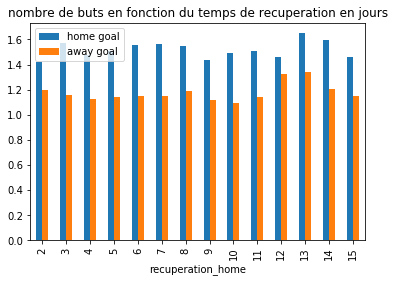

In [35]:
df_home = pd.DataFrame(match[['recuperation_home','home_team_goal']].groupby(by='recuperation_home').mean()).sort_index()
df_away = pd.DataFrame(match[['recuperation_away','away_team_goal']].groupby(by='recuperation_away').mean()).sort_index()

#on merge les deux
df_home_away = df_home.merge(df_away, how='outer', left_index=True, right_index=True)
df_home_away.columns = ['home goal', 'away goal']

#on affiche les deux histogrammes
df_home_away.plot(kind='bar', title='nombre de buts en fonction du temps de recuperation en jours')

On observe pas vraiment d'effet, sauf peut être sur la fin...

On calcule maintenant la dynamique :

In [36]:
def vainqueur(row):
    if row.home_team_goal > row.away_team_goal:
        return 'H'
    elif row.home_team_goal < row.away_team_goal:
        return 'A'
    else:
        return 'N'
    
match['vainqueur'] = match.apply(vainqueur, axis=1)

In [37]:
def dynamique(row, home=True):
    # on récupère l'équipe et la date du match
    if home:
        equipe, jourJ = (row.home_team_api_id, row.date)
    else:
        equipe, jourJ = (row.away_team_api_id, row.date)
        
    match_precedents = match[:row.name][(match.home_team_api_id == equipe) | (match.away_team_api_id == equipe)]
    
    # On reindex
    match_precedents.index = range(0,len(match_precedents))
    
    dyn = ''
    # On prend maximum les 5 derniers matchs
    for i in range(min(5,match_precedents.id.count())):
        current_row = match_precedents.iloc[[i-1]]
        # Si l'équipe qu'on regarde a joué à domicile
        if equipe == current_row.home_team_api_id.values:
            if current_row.vainqueur.values == 'H':
                dyn += 'G'
            elif current_row.vainqueur.values == 'A':
                dyn += 'P'
            else:
                dyn += 'N'
        # Sinon c'est que c'était l'équipe qui jouait à l'exterieur
        else:
            if current_row.vainqueur.values == 'A':
                dyn += 'G'
            elif current_row.vainqueur.values == 'H':
                dyn += 'P'
            else:
                dyn += 'N'
                
    
    # Si il n'existe pas de match avant, on rempli par des matchs nuls            
    if len(dyn) < 5:
        dyn = dyn + ('N' * (5-len(dyn)))
        
    return dyn[::-1] # on renverse la chaine de caractère, car on veut du plus vieux au plus jeune de gauche à droite
    
match['home_dynamique'] = match.apply(lambda row: dynamique(row), axis=1)
match['away_dynamique'] = match.apply(lambda row: dynamique(row, home=False), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [38]:
def score_dyn(dyn):
    score = 0
    for i in range(5):
        score = score + (1 if dyn[i] == 'G' else -1 if dyn[i] == 'P' else 0) * (float(i+1)/float(5))
    return score

match['home_score_dynamique'] = match.home_dynamique.apply(score_dyn)
match['away_score_dynamique'] = match.away_dynamique.apply(score_dyn)

On enregistre la nouvelle base de données (le calcul a pris des heures, on va pas le faire à chaque fois...)

In [ ]:
match.to_csv('data\\match_enhanced.csv', encoding='utf-8')

## Construction du modèle

On charge les données si on les avais pas avant

In [1]:
import pandas as pd
import numpy as np
match = pd.read_csv('data\\match_enhanced.csv', index_col=0, parse_dates=[3], infer_datetime_format=True)

On va désormais se concentrer sur la ligue 1 anglaise car c'est celle qui possède le plus de données (on pourrait pour l'instant travailler sur les autres, mais ce sera bloquant dans le prochain notebook)

In [2]:
match_league1 = match[match.league_id == 1729]

In [3]:
match_league1.drop(['id','league_id','date','goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'],
           axis=1, inplace=True)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [4]:
match_league1

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name,recuperation_home,recuperation_away,vainqueur,home_dynamique,away_dynamique,home_score_dynamique,away_score_dynamique
53,8668,8655,2,3,Everton,Blackburn Rovers,15,15,A,NNNNN,NNNNN,0.000000e+00,0.0
55,9825,8659,1,0,Arsenal,West Bromwich Albion,15,15,H,NNNNN,NNNNN,0.000000e+00,0.0
69,8559,10194,3,1,Bolton Wanderers,Stoke City,15,15,H,NNNNN,NNNNN,0.000000e+00,0.0
73,8549,8586,2,1,Middlesbrough,Tottenham Hotspur,15,15,H,NNNNN,NNNNN,0.000000e+00,0.0
78,8472,8650,0,1,Sunderland,Liverpool,15,15,A,NNNNN,NNNNN,0.000000e+00,0.0
83,8654,8528,2,1,West Ham United,Wigan Athletic,15,15,H,NNNNN,NNNNN,0.000000e+00,0.0
84,8667,9879,2,1,Hull City,Fulham,15,15,H,NNNNN,NNNNN,0.000000e+00,0.0
89,8455,8462,4,0,Chelsea,Portsmouth,15,15,H,NNNNN,NNNNN,0.000000e+00,0.0
91,10260,10261,1,1,Manchester United,Newcastle United,15,15,N,NNNNN,NNNNN,0.000000e+00,0.0
99,10252,8456,4,2,Aston Villa,Manchester City,15,15,H,NNNNN,NNNNN,0.000000e+00,0.0


Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Déjà, on va se concentrer maintenant sur la ligue 1 anglaise car c'est celle qui possède le plus de données. Ensuite, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [5]:
teams = match_league1.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
num_teams = len(match_league1.away_team_api_id.unique())

In [6]:
teams

,team,i
0,Everton,0
1,Arsenal,1
2,Bolton Wanderers,2
3,Middlesbrough,3
4,Sunderland,4
5,West Ham United,5
6,Hull City,6
7,Chelsea,7
8,Manchester United,8
9,Aston Villa,9


In [7]:
match_league1 = pd.merge(match_league1, teams, left_on='home_team_long_name', right_on='team', how='left')
match_league1 = match_league1.rename(columns = {'i': 'i_home'}).drop('team', 1)
match_league1 = pd.merge(match_league1, teams, left_on='away_team_long_name', right_on='team', how='left')
match_league1 = match_league1.rename(columns = {'i': 'i_away'}).drop('team', 1)

On split notre jeu de données (60/20/20) afin de pouvoir mesurer plus tard les perfomances des différents modèles testés. NB : on fait exprès de ne pas randomiser les individus qui iront en train/CV/test. En effet, les observations sont ordonnées dans le temps, et en application réelle, on a accès uniquement au passé pour prédire le futur.

In [8]:
# On compte le nombre d'observations dont on dispose
taille_totale = match_league1.home_team_goal.count()
# on calcule le nombre d'observations que l'on envoie en training set
train_size = int(taille_totale*0.6)
CV_size = int(taille_totale*0.8)

observed_home_goals = match_league1.home_team_goal.values[:train_size]
observed_away_goals = match_league1.away_team_goal.values[:train_size]

home_team = match_league1.i_home.values[:train_size]
away_team = match_league1.i_away.values[:train_size]

home_recuperation = np.array(match_league1.recuperation_home.values[:train_size], dtype=np.float64)
away_recuperation = np.array(match_league1.recuperation_away.values[:train_size], dtype=np.float64)

home_dynamique = np.array(match_league1.home_score_dynamique.values[:train_size], dtype=np.float64)
away_dynamique = np.array(match_league1.away_score_dynamique.values[:train_size], dtype=np.float64)

On décrit notre modélisation. On commence par spécifier les entrées et sorties de notre modélisation ![title](illustrations/V2.png)

In [9]:
import theano

model_input_team = theano.shared(np.array([home_team, away_team]))
model_input_conditions = theano.shared(np.array([home_recuperation, away_recuperation, home_dynamique, away_dynamique]))
model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

Puis on écrit le modèle

In [10]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:
    # shape parameter des lois de student et de la loi normale pour le bruit 
    hyper_lambda_team = pm.Uniform('hyper_lambda_team', lower=0, upper=5, shape=1)
    hyper_lambda_coeff = pm.Uniform('hyper_lambda_coeff', lower=0, upper=5, shape=1)  
    
    # Paramètres spécifiques à chaque équipe  
    attaque = pm.StudentT("attaque", nu=2, mu=0, lam=hyper_lambda_team, shape=num_teams)
    defense = pm.StudentT("defense", nu=2, mu=0, lam=hyper_lambda_team, shape=num_teams)
    
    # Paramètre lié aux conditions du match
    coeff_home = pm.StudentT("coeff_home", nu=2, mu=0, lam=hyper_lambda_coeff, shape=1)
    coeff_recup = pm.StudentT("coeff_recup", nu=2, mu=0, lam=hyper_lambda_coeff, shape=1)
    coeff_dynamique = pm.StudentT("coeff_dynamique", nu=2, mu=0, lam=hyper_lambda_coeff, shape=1)
    coeff_perf = pm.StudentT("coeff_perf", nu=2, mu=0, lam=hyper_lambda_coeff, shape=1)
    
    # et un intercept
    intercept = pm.Normal("intercept", mu=0, sd=hyper_lambda_coeff, shape=1)
    
    home_theta  = pm.math.exp(intercept + 
                              coeff_home + 
                              coeff_recup * (model_input_conditions[0] - model_input_conditions[1]) + 
                              coeff_dynamique * (model_input_conditions[2] - model_input_conditions[3]) +
                              coeff_perf * (attaque[model_input_team[0]] - defense[model_input_team[1]])
                              )
    away_theta  = pm.math.exp(intercept + 
                              coeff_recup * (model_input_conditions[1] - model_input_conditions[0]) +
                              coeff_dynamique * (model_input_conditions[3] - model_input_conditions[2]) +
                              coeff_perf * (attaque[model_input_team[1]] - defense[model_input_team[0]])
                             )

    # likelihood of observed data 
    home_points = pm.Poisson('home_points', mu=home_theta, observed=model_output[0])
    away_points = pm.Poisson('away_points', mu=away_theta, observed=model_output[1])

In [11]:
with model:
    trace = pm.sample(100, n_init=20000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -5,766.6: 100%|███████████████████████████████████████████████████| 20000/20000 [08:03<00:00, 43.30it/s]
Finished [100%]: Average ELBO = -5,598.7
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:41<00:00,  1.18it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002AB395C0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000290EAE80>]], dtype=object)

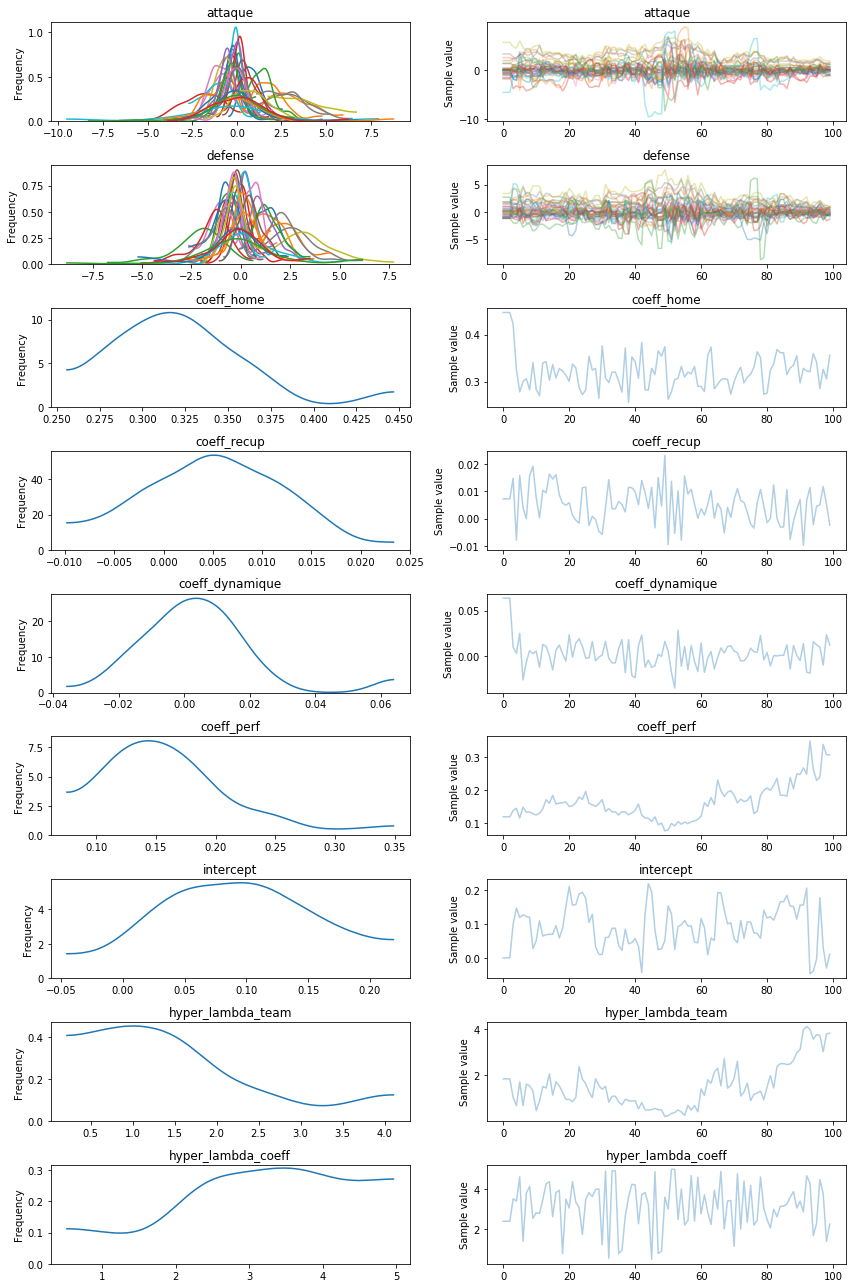

In [14]:
pm.traceplot(trace)

La phase de sampling étant terminé, on va afficher pour chaque équipe la ditribution à posteriori des paramètres d'attaque et de défense sous forme de forestplot : 

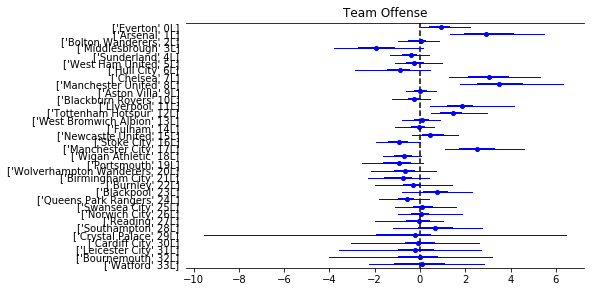

In [15]:
pm.forestplot(trace[10:], varnames=['attaque'], ylabels=teams.values, main="Team Offense", chain_spacing=1)

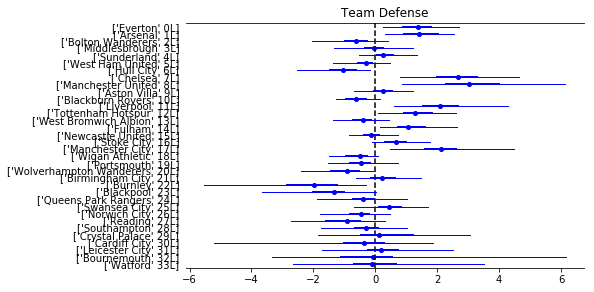

In [16]:
pm.forestplot(trace[10:], varnames=['defense'], ylabels=teams.values, main="Team Defense", chain_spacing=1)

Les résultats semblent cohérents (le trio de tête est Chelsea - Manchester United - Arsenal). On enregistre donc la trace afin de pouvoir s'en reservir dans le programme final :

In [17]:
with model:
    db = pm.backends.text.Text(name='Trace')
    trace = pm.sample(2000, n_init=20000, trace=db)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -5,766.6: 100%|███████████████████████████████████████████████████| 20000/20000 [07:52<00:00, 42.34it/s]
Finished [100%]: Average ELBO = -5,598.7
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [37:40<00:00,  1.22s/it]


# Evaluation des perfomances du modèle

On mesure maintenant les performances du modèle. La méthode est la même quand le notebook précédent, on va donc condenser les cellules et enlever les textes de commentaire.

In [18]:
"""On définit les nouvelles entrées et sorties"""
observed_home_goals = match_league1.home_team_goal.values[train_size+1:CV_size]
observed_away_goals = match_league1.away_team_goal.values[train_size+1:CV_size]

home_team = match_league1.i_home.values[train_size+1:CV_size]
away_team = match_league1.i_away.values[train_size+1:CV_size]

home_recuperation = np.array(match_league1.recuperation_home.values[train_size+1:CV_size], dtype=np.float64)
away_recuperation = np.array(match_league1.recuperation_away.values[train_size+1:CV_size], dtype=np.float64)

home_dynamique = np.array(match_league1.home_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)
away_dynamique = np.array(match_league1.away_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)

"""On les rentres dans les shared value theano"""
model_input_team.set_value(np.array([home_team,away_team], dtype=np.int32))
model_input_conditions.set_value(np.array([home_recuperation,away_recuperation,home_dynamique,away_dynamique], dtype=np.float64))

"""Et on sample"""
ppc = pm.sample_ppc(trace[10:], model=model, samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  1.52s/it]


L'échantillon est désormais créé, on va maintenant comparer nos prédictions avec la réalité :

In [19]:
"""On rassemble dans des dataframe"""
away_prediction = pd.DataFrame(ppc['away_points'])
home_prediction = pd.DataFrame(ppc['home_points'])  

prediction_score = [home_prediction[[i]].merge(away_prediction[[i]], 
                                               how='inner', 
                                               left_index=True, right_index=True) 
                    for i in range(len(home_team))]

for df in prediction_score:
    df.columns = ['home_prediction', 'away_prediction']
    
"""Pour chaque dataframe, on détermine l'équipe qui gagne"""
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'
    
for df in prediction_score:
    df['prediction_vainqueur'] = df.apply(vainqueur, axis=1) 
    
"""Et on ajoute le score le plus probable"""
resultats = list()
    
for df in prediction_score:
    home_score, away_score = df.groupby(["home_prediction", "away_prediction"]).size().idxmax()
    resultats.append(
        [df.prediction_vainqueur.value_counts().idxmax(), home_score, away_score]
    )
    
resultats = pd.DataFrame(np.array(resultats))
resultats.columns = ['prediction_vainqueur', 'prediction_home_score', 'prediction_away_score']

#on remet les scores au type int, sinon il sont converti en 'objet' ...
resultats[['prediction_home_score', 'prediction_away_score']] = resultats[['prediction_home_score', 'prediction_away_score']].astype(np.int32)

"""Enfin on met en forme les vrais résultats pour pouvoir comparer"""
vrai_home = pd.DataFrame(observed_home_goals)
vrai_away = pd.DataFrame(observed_away_goals) 

vrai_resultats = vrai_home.merge(vrai_away, how='inner', left_index=True, right_index=True)
vrai_resultats.columns = ['home_points', 'away_points']

vrai_resultats['vainqueur'] = vrai_resultats.apply(vainqueur, axis=1)

vrai_resultats = vrai_resultats.merge(resultats, how='inner', left_index=True, right_index=True)

In [20]:
vrai_resultats

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
0,3,2,H,H,1,1
1,1,3,A,H,1,1
2,2,2,N,H,1,0
3,0,2,A,A,1,1
4,1,2,A,A,1,2
5,2,1,H,H,1,0
6,1,1,N,H,1,1
7,1,0,H,H,0,1
8,0,0,N,H,1,0
9,2,2,N,H,1,0


On calcule notre score :

In [21]:
from sklearn import metrics

metrics.accuracy_score(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)

0.53706754530477763

Commentaires : C'est un peu mieux que avant (0.519 vs 0.537)

In [22]:
vrai_resultats.vainqueur.count()

607

In [23]:
vrai_resultats.vainqueur.value_counts() / vrai_resultats.vainqueur.count()

H    0.444811
A    0.314662
N    0.240527
Name: vainqueur, dtype: float64

prochaine étapes :
- Améliorer l'information sur les buts en utilisant les tirs cadrés, les corners, etc.

Enfin, on va compter le nombre de fois où notre projection de score est correcte

In [24]:
score_juste = vrai_resultats[vrai_resultats.home_points == vrai_resultats.prediction_home_score]
score_juste = score_juste[vrai_resultats.away_points == vrai_resultats.prediction_away_score]
len(score_juste) / float(len(vrai_resultats))

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


0.10214168039538715

On a prédit le bon score dans 14.5% des cas.

# Idem mais sur les données de test

On mesure maintenant les performances du modèle. La méthode est la même quand le notebook précédent, on va donc condenser les cellules et enlever les textes de commentaire.

In [25]:
"""On définit les nouvelles entrées et sorties"""
observed_home_goals = match_league1.home_team_goal.values[CV_size+1:]
observed_away_goals = match_league1.away_team_goal.values[CV_size+1:]

home_team = match_league1.i_home.values[CV_size+1:]
away_team = match_league1.i_away.values[CV_size+1:]

home_recuperation = np.array(match_league1.recuperation_home.values[CV_size+1:], dtype=np.float64)
away_recuperation = np.array(match_league1.recuperation_away.values[CV_size+1:], dtype=np.float64)

home_dynamique = np.array(match_league1.home_score_dynamique.values[CV_size+1:], dtype=np.float64)
away_dynamique = np.array(match_league1.away_score_dynamique.values[CV_size+1:], dtype=np.float64)

"""On les rentres dans les shared value theano"""
model_input_team.set_value(np.array([home_team,away_team], dtype=np.int32))
model_input_conditions.set_value(np.array([home_recuperation,away_recuperation,home_dynamique,away_dynamique], dtype=np.float64))

"""Et on sample"""
ppc = pm.sample_ppc(trace[10:], model=model, samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.73s/it]


L'échantillon est désormais créé, on va maintenant comparer nos prédictions avec la réalité :

In [26]:
"""On rassemble dans des dataframe"""
away_prediction = pd.DataFrame(ppc['away_points'])
home_prediction = pd.DataFrame(ppc['home_points'])  

prediction_score = [home_prediction[[i]].merge(away_prediction[[i]], 
                                               how='inner', 
                                               left_index=True, right_index=True) 
                    for i in range(len(home_team))]

for df in prediction_score:
    df.columns = ['home_prediction', 'away_prediction']
    
"""Pour chaque dataframe, on détermine l'équipe qui gagne"""
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'
    
for df in prediction_score:
    df['prediction_vainqueur'] = df.apply(vainqueur, axis=1) 
    
"""Et on ajoute le score le plus probable"""
resultats = list()
    
for df in prediction_score:
    home_score, away_score = df.groupby(["home_prediction", "away_prediction"]).size().idxmax()
    resultats.append(
        [df.prediction_vainqueur.value_counts().idxmax(), home_score, away_score]
    )
    
resultats = pd.DataFrame(np.array(resultats))
resultats.columns = ['prediction_vainqueur', 'prediction_home_score', 'prediction_away_score']

#on remet les scores au type int, sinon il sont converti en 'objet' ...
resultats[['prediction_home_score', 'prediction_away_score']] = resultats[['prediction_home_score', 'prediction_away_score']].astype(np.int32)

"""Enfin on met en forme les vrais résultats pour pouvoir comparer"""
vrai_home = pd.DataFrame(observed_home_goals)
vrai_away = pd.DataFrame(observed_away_goals) 

vrai_resultats = vrai_home.merge(vrai_away, how='inner', left_index=True, right_index=True)
vrai_resultats.columns = ['home_points', 'away_points']

vrai_resultats['vainqueur'] = vrai_resultats.apply(vainqueur, axis=1)

vrai_resultats = vrai_resultats.merge(resultats, how='inner', left_index=True, right_index=True)

In [27]:
vrai_resultats

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
0,0,1,A,A,1,1
1,2,0,H,H,3,0
2,1,0,H,H,1,1
3,1,1,N,H,1,0
4,3,0,H,H,1,0
5,1,2,A,A,1,0
6,3,1,H,H,2,0
7,3,0,H,H,0,0
8,1,1,N,A,0,1
9,2,0,H,H,1,1


On calcule notre score :

In [28]:
from sklearn import metrics

metrics.accuracy_score(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)

0.48764415156507412

Commentaires : C'est un peu mieux que avant (0.519 vs 0.537)

In [29]:
vrai_resultats.vainqueur.count()

607

In [30]:
vrai_resultats.vainqueur.value_counts() / vrai_resultats.vainqueur.count()

H    0.433278
A    0.309720
N    0.257002
Name: vainqueur, dtype: float64

Enfin, on va compter le nombre de fois où notre projection de score est correcte

In [31]:
score_juste = vrai_resultats[vrai_resultats.home_points == vrai_resultats.prediction_home_score]
score_juste = score_juste[vrai_resultats.away_points == vrai_resultats.prediction_away_score]
len(score_juste) / float(len(vrai_resultats))

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


0.09884678747940692

On a prédit le bon score dans 14.5% des cas.